# De-Reverberation Initial Investigation

### Setup and Installations

In [1]:
%matplotlib inline

### Imports

In [2]:
#%%writefile imports.py

# Pytorch Stuff
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import torchaudio.functional as taf

# Librosa for audio stuff/plotting spectrograms
import numpy as np
import librosa as lr
from librosa.display import *


# Plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

# Utilities
from IPython.display import Audio
from tqdm import tqdm_notebook as tqdm # progress bars
import random
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

### Convenience Functions

In [3]:
# %%writefile utils.py
# from imports import *

# Shorthand amplitude->db conversion
db = lambda x: lr.amplitude_to_db(x)

def plot_spec(sig,sr=22050, channel=None):
    """
    Plots spectrogram of time domain signal (numpy or tensor) with default parameters.
    channel: selects one channel if input has multiple channels
    """
    if type(sig) is torch.Tensor:
        sig = sig.squeeze().numpy()
    if channel != None:
        sig = sig[:,channel].squeeze()
    spec = db(abs(lr.stft(sig))) 
    specshow(spec, x_axis='time', y_axis='mel', sr=sr)

In [1]:
%%writefile AudioTransforms.py
from imports import *

class Noise(object):
    """ Adds a random noise file to the original signal at a random normally distributed amplitude
    """
    def __init__(self, noise_path, noise_sr=None, db_mean=-12, db_sd=3, use_cuda=False):
        """
        Args:
            noise_path (str|Path): path to noise files, or list of files
            noise_sr (int): rate at which to resample noise files. If None, uses native sample rate.
            db_mean (float|int): mean amplitude of noise w.r.t. speech signal in decibels (default: -12)
            db_sd (float|int): standard deviation of noise amplitude in decibels (default: 3)
        """
        if type(noise_path) is not list:
            noise_path = list(noise_path.glob('*.wav'))
            
        self.noises, self.srs = zip(*[ta.load(x) for x in tqdm(noise_path, desc='Loading Noises...')])
        
        if use_cuda:
            self.noises = [x.cuda() for x in self.noises]
            
        if noise_sr:
            self.noises = [ta.transforms.Resample(self.srs[i], noise_sr)(self.noises[i]) for i in 
                           tqdm(range(len(self.noises)), desc='Resampling Noises...')]
            
        self.db_dist = (db_mean, db_sd)
        
    def __call__(self, speech):
        db = np.random.normal(self.db_dist[0], self.db_dist[1])
        amp = lr.db_to_amplitude(db)
        n = random.choice(self.noises)
        if speech.shape[-1] < n.shape[-1]:
            return speech + amp * n[:,:speech.shape[-1]]
        else:
            return speech[:,:n.shape[-1]] + amp * n

class Reverb(object):
    """ Adds a convolutional reverb to the speech from a randomly chosen impulse response
        Crops the beginning of the impulse response to non-silent parts to maintain time-alignment of input and target
    """
    def __init__(self, ir_path, ir_sr=None, ir_mono=True, use_cuda=False):
        """
        Args:
            ir_path (str|Path): path to a directory of impulse responses or list of files
            ir_sr (int): rate at which to resample impulse responses. if None (default) uses native sample rate.
            ir_mono (bool): if true, loads only first channel of impulse response, else loads all channels
        """
        if type(ir_path) is not list:
            ir_path = list(ir_path.glob('*.wav'))
            
        self.irs, self.srs = zip(*[ta.load(x) for x in tqdm(ir_path, desc='Loading Impulse Responses...')])
        
        if ir_sr:
            self.irs = [ta.transforms.Resample(self.srs[i], ir_sr)(self.irs[i]) for i in 
                        tqdm(range(len(self.irs)), desc='Resampling Impulse Responses...')]
        if ir_mono:
            self.irs = [x[0,:] for x in self.irs]
            
        if use_cuda:
            self.irs = [x.cuda() for x in self.irs]
            
        # Crop beginning silence of IRS
        crop_idxs = [x.argmax(-1) for x in self.irs]
        self.irs = [x[crop_idxs[i]:].unsqueeze(0).unsqueeze(1) for i,x in enumerate(self.irs)]
    
    def __call__(self, speech):
        
        ir = random.choice(self.irs)
        if ir.shape[-1] < speech.shape[-1]:
            padding = ir.shape[-1]
            inputs, filters = speech.unsqueeze(0), ir.flip(-1)
        else:
            padding = speech.shape[-1]
            inputs, filters = ir, speech.unsqueeze(0).flip(-1)
            
        return F.conv1d(inputs, filters, padding=padding)[0,:,:speech.shape[-1]]
        
        # TODO: replace this with torch.conv1d
        #return torch.Tensor(np.convolve(speech.squeeze().numpy(), ir.squeeze().numpy(), 'same')).unsqueeze(0)

class RandomCrop(object):
    """ Crop sample to fixed length starting at random position. Pads with zeros if sample not long enough.
    """
    def __init__(self, length, no_rand=False):
        """
        Args:
            length (int): length of returned clips in samples
            no_rand (bool): if true will always start at beginning of clip. (default: False)
        """
        self.crop_len = length
        self.no_rand = no_rand
        
    def __call__(self, speech):
        if self.no_rand:
            start = 0
        else:
            start = random.randint(0, abs(speech.shape[-1]-self.crop_len))
            
        if speech.shape[-1] > self.crop_len:
            return speech[:,start:start+self.crop_len]
        else:
            retval = torch.zeros((1,self.crop_len))
            retval[:,0:speech.shape[-1]] = speech
            return retval

Overwriting AudioTransforms.py


### Question: noise->convolve or convolve->noise?

In [77]:
speech_sr = 16000

In [78]:
rev_tfms = transforms.Compose([#Noise(Path('data/noise'), speech_sr, -6, 2), 
                               Reverb(Path('data/impulse-responses'), speech_sr)])
clean_tfms = transforms.Compose([RandomCrop(2*speech_sr)])

In [7]:
%%writefile DeReverbDataset.py
from imports import *

class DeReverbDataset(Dataset):
    """
    Pytorch dataset for audio sequence to sequence tasks. 
    """
    def __init__(self, root_path, 
                 speech_path='clean-speech', 
                 ir_path='impulse-responses', 
                 noise_path='noise', 
                 rev_tfms=None, 
                 clean_tfms=None, 
                 use_cuda=False):
        self.rp = Path(root_path)
        if speech_path
        self.speech_files = (self.rp/speech_path).ls()
        self.ir_files = (self.rp/ir_path).ls()
        self.noise_files = (self.rp/noise_path).ls()
        self.rev_tfms = rev_tfms
        self.clean_tfms = clean_tfms
        self.use_cuda = use_cuda
        
    def __len__(self):
        return len(self.speech_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sfn = self.speech_files[idx]
        speech, ssr = ta.load(sfn)
        
        # Transforms change the clean speech, adding noise, reverb and 
        # other effects.
        if self.clean_tfms:
            speech = self.clean_tfms(speech)
            
        if self.use_cuda:
            speech = speech.cuda()
            
        if self.rev_tfms:
            reverbed = self.rev_tfms(speech)
            
            
        
        reverbed = torch.Tensor(reverbed)
        speech = torch.Tensor(speech)
        sample = {'reverbed': reverbed, 'clean': speech}
        return sample

Overwriting DeReverbDataset.py


In [80]:
data = Path("data/")
speech = data/'clean-speech'
irs = data/'impulse-responses'
noise = data/'noise'

In [81]:
dataset = DeReverbDataset("data", rev_tfms=rev_tfms, clean_tfms=clean_tfms)

In [82]:
dataset[0]['reverbed'].shape

torch.Size([1, 32000])

In [83]:
dataset[0]['clean'].shape

torch.Size([1, 32000])

### Plot and Listen to Example Transformed Data

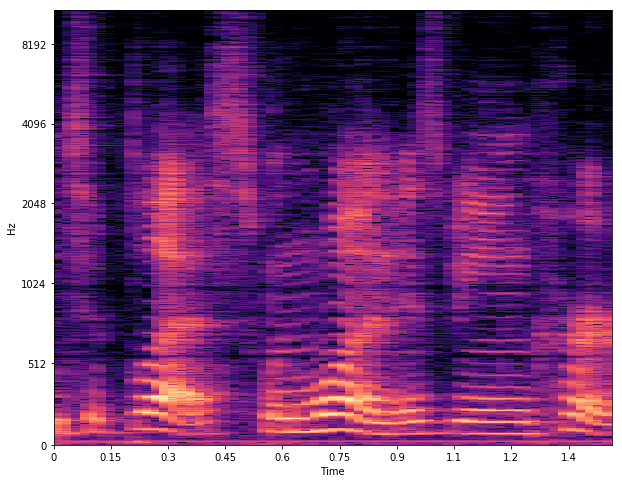

In [84]:
ex = dataset.__getitem__(random.choice(range(len(dataset))))

plot_spec(ex['reverbed'])
Audio(ex['reverbed'].squeeze(), rate=16000)

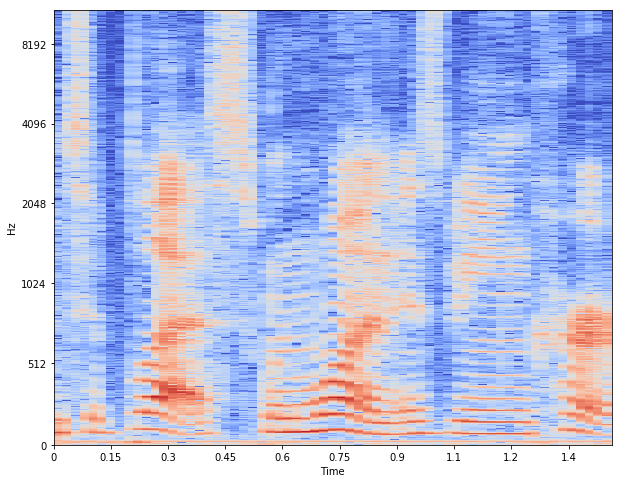

In [85]:
plot_spec(ex['clean'])
Audio(ex['clean'], rate=16000)

In [ ]:
dl = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [ ]:
%%time
next(iter(dl))

# Model
(garbage for now)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Recur_Reverb(nn.Module):
    def __init__(self, hidden_dim):
        super(Recur_Reverb, self,).__init__()
        self.lstm = nn.LSTM(1, hidden_dim, batch_first=True)
        
        self.l_out = nn.Linear(in_features=hidden_dim, out_features=1, bias=False)
        
    def forward(self, x):
        x = x.unsqueeze(-1)
        x, (_,_) = self.lstm(x)
        
        print(x.shape)
        x = x.view(x.shape[0], -1)
        
        x = self.l_out(x)
        return x

In [ ]:
n_epochs = 5

hid_dim = 128
net = Recur_Reverb(hid_dim).cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-3)

losses = []
for i in tqdm(range(n_epochs)):
    epoch_loss = 0
    net.train()
    for batchid,batch in tqdm(enumerate(dl)):
        inputs = batch['reverbed'].cuda()
        targets = batch['clean'].cuda()
        print(inputs.shape)
        
        
        #print(f'target: {target.shape}')
        #print(f'outsig: {outsig.shape}')
        outputs = net(inputs)

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.detach().numpy()
        
    print(epoch_loss)
    losses.append(epoch_loss/len(dl))